## Time Series Model
![TimeSeriesModel](tsa_image/TimeSeriesModel.PNG)

# Forecasting Models 
## SMA, WMA, SES, ARIMA
- 기존 머신러닝 모델들이 더 정확하긴 하지만, 정확도가 조금 떨어지더라도 Trend를 읽어낼 수 있는 강점이 있음


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

airline = pd.read_csv('tsa_data/airline_passengers.csv', index_col='Month', parse_dates=True)
print(airline.shape)
airline.head()

(144, 1)


,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 1. Simple Moving Average
- Moving Average 구하는 방법에 대해서는 앞서 rolling mean 을 통해 알아본 바 있습니다.
![SMA_image](tsa_image/SMA_image.PNG)

In [27]:
airline['3M SMA'] = airline['Thousands of Passengers'].rolling(window=3).mean()
airline['6M SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline

,Thousands of Passengers,3M SMA,6M SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,120.666667,NaN
1949-04-01,129,126.333333,NaN
1949-05-01,121,127.333333,NaN
...,...,...,...
1960-08-01,606,587.666667,519.166667
1960-09-01,508,578.666667,534.000000
1960-10-01,461,525.000000,534.000000


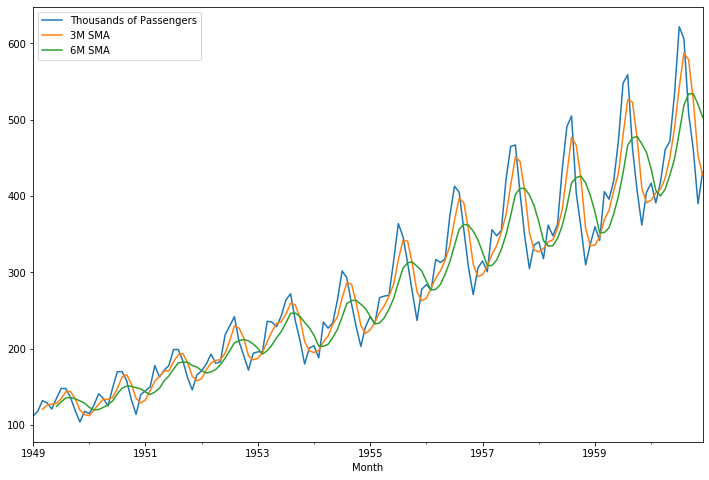

In [28]:
# MA 그래프
# 원래값, 3MA, 6MA 값 그래프로 확인
airline.plot(figsize=(12,8))

- **문제점 : missing 값도 많고 / Trend도 늦게 반영 /  MA 기 때문에 극단값을 쫓아가지를 못함 = Max값이 매우 높은 뾰족한 값이 있을떄 평균을 줘버리니까 무조건 낮아짐.**
- 뾰족점에서 기존것보다 3M가 낮고, 3M보다 6M이 낮음. -> 잔차도 커질 것임.
- Weighted Moving Average 나옴.

## 2. Weighted Moving Average
- 가중치를 준 MA
![WMA_image](tsa_image/WMA_image.PNG)

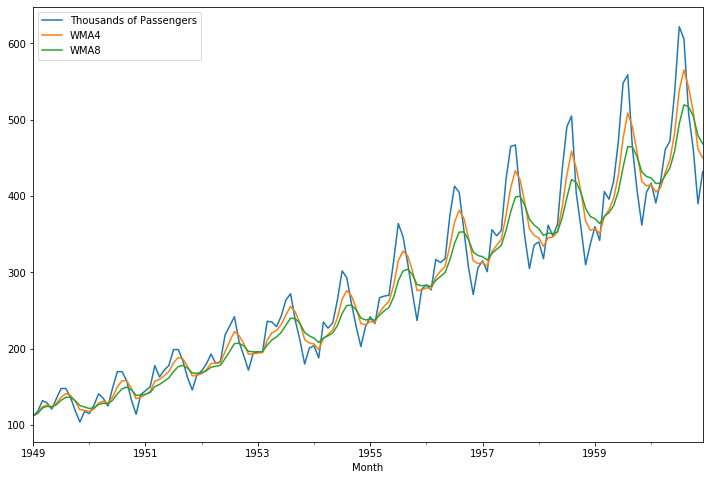

In [29]:
airline['WMA4'] = airline['Thousands of Passengers'].ewm(span=4).mean()
airline['WMA8'] = airline['Thousands of Passengers'].ewm(span=8).mean()

airline[['Thousands of Passengers', 'WMA4','WMA8']].plot(figsize=(12,8))

- 좀더 뾰족함. 편차가 줄어들음. 최신 데이터를 반영해서 약간 고저를 잘 따라가는 느낌.
- **기존 MA는 뒤로 밀리는 느낌이 있었는데, WMA는 어느정도 잘 따라감.**

## Simple Exponential Smoothing / Holt's / Holt-WInter's
- **Simple Exponential Smoothing : Trend, Seasnality 반영 못함**
- **Holt's 는 Trend를 반영. Seanoality는 반영못함**
- **Holt-Witer는 Trend와 Seasonality 둘다 반영함**
- 이제부터는 학습필요.

## 3. Simple Exponential Smoothing (단순지수평활)
- 추세나 계절성 패턴이 없는 데이터를 예측할 때 쓰기 좋음.
- $Y_t = aX_t + (1-a)Y_{t-1}$
![SES_image](tsa_image/SES_image.PNG)

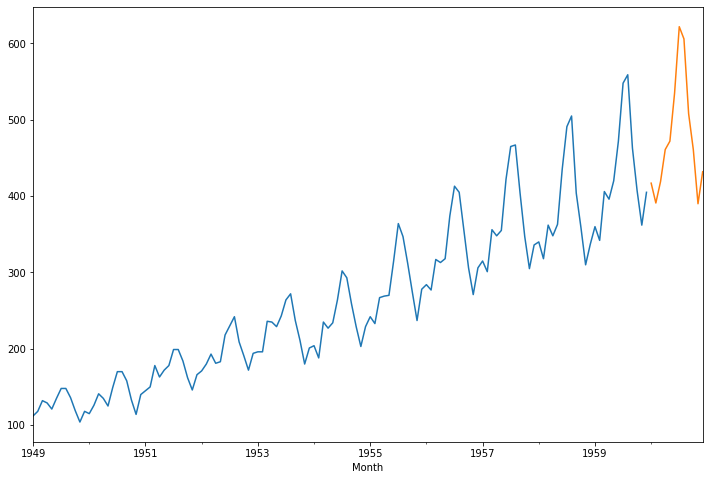

In [30]:
# Simple Exponential Smoothing
from statsmodels.tsa.api import SimpleExpSmoothing

# Train, test 구별.
train = airline[:'1959']
test = airline['1960':]

# train 과 test 그리기
train['Thousands of Passengers'].plot(figsize=(12,8))
test['Thousands of Passengers'].plot()

# 모델 학습 
ses_model = SimpleExpSmoothing(np.asarray(train['Thousands of Passengers']))
ses_result = ses_model.fit()

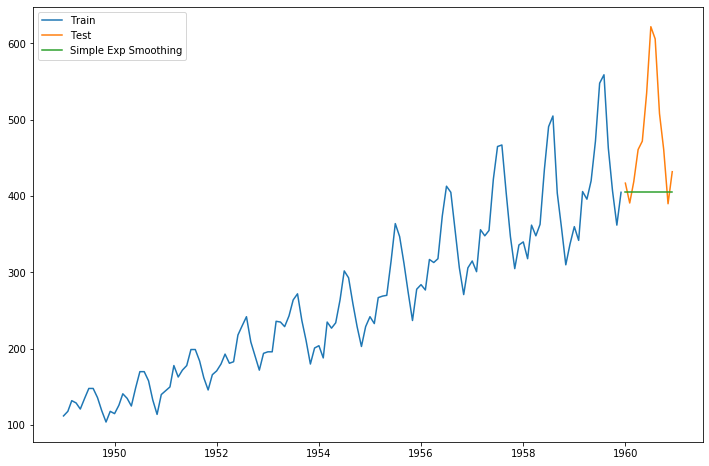

In [31]:
# Simple Exponential Smoothing

# 예측값 (predict 해보기위해서)
y_hat = test.copy()
y_hat['SES'] = ses_result.forecast(len(test)) # forecast = predict랑 같은 것.

plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['SES'], label='Simple Exp Smoothing')
plt.legend()

- 거의 예측을 못함.

In [32]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'], y_hat['SES']))
rmse

102.97653454387881

## Holt's Method
- **Holt's 는 Trend만 반영. Seanoality는 반영못함**


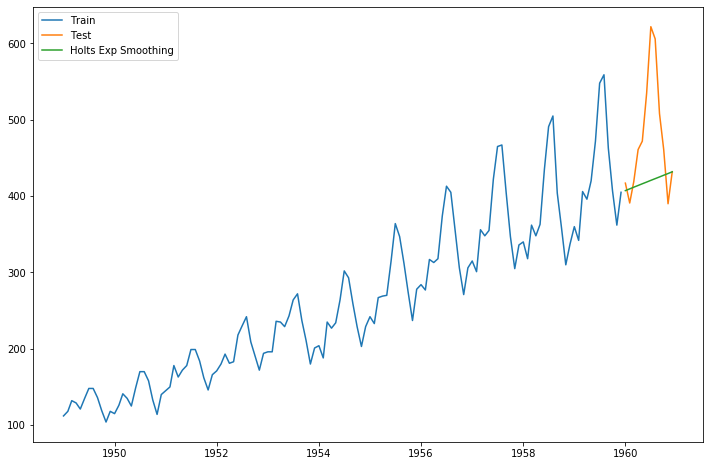

In [33]:
from statsmodels.tsa.api import Holt

holt_model = Holt(np.asarray(train['Thousands of Passengers']))

# 학습
holt_result = holt_model.fit()

# predict - forecast 함수.
y_hat['HOLT'] = holt_result.forecast(len(test))

plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['HOLT'], label='Holts Exp Smoothing')
plt.legend()

- **Trend를 반영했으나 Seanonality는 반영못함.**
- **Trend를 반영하였다. 어느정도 증가하는 추세.**
- **Seasonality를 반영못하였다 -> 오르락 내리락 하는것이 아닌 그냥 직선.**

In [34]:
# 평가결과
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'], y_hat['HOLT']))
rmse

92.66627771653796

## Holt-Winters Method
- **Holt-Witer는 Trend와 Seasonality 둘다 반영함**

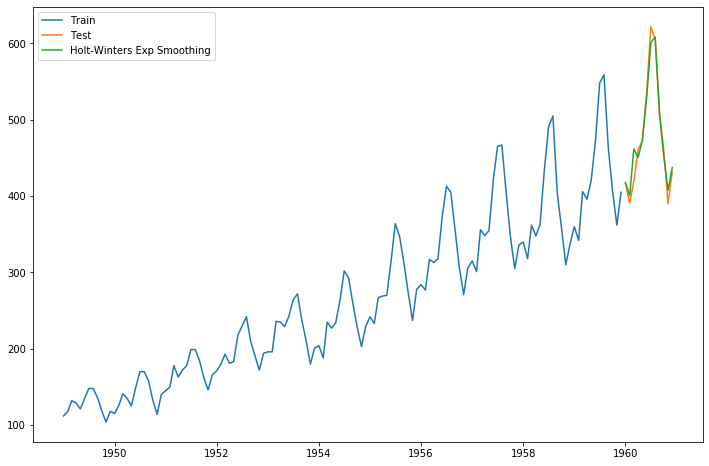

In [35]:
from statsmodels.tsa.api import ExponentialSmoothing

# winter_model 
winter_model = ExponentialSmoothing(
    np.asarray(train['Thousands of Passengers']),
    seasonal_periods=12, # 연단위 주기를 보이기 때문에 12 - 샘플이 월단위니까. 
    trend='add', # additive model
    seasonal='add' # additive model
)

# 학습
winter_result = winter_model.fit()

# predict - forecast 함수
y_hat['WINTER'] = winter_result.forecast(len(test))

# 그래프 그리기
plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['WINTER'], label='Holt-Winters Exp Smoothing')
plt.legend()

- **Trend와 Seaonality 모두를 잘 반영함**
- **Trend와 Seaonality가 어느정도 확실하다 라고 하면 HOlt-Winter만 가지고도 예측 할 수 있음. 하지만 항상 그렇지는 않기 떄문에 나온게 ARIMA Model**

In [36]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'],y_hat['WINTER']))
rmse

15.570830861607387

## ARIMA (AutoRegressive Integranted Moving Average)
- Autoregressive Integrated Moving Average는 개발된지 오래된 방법으로 시계열 데이터 분석을 위해 이해해야 하는 중요한 모델링 또는 예측 기법
- 지수평활 모델은 데이터의 추세와 계절성(seasonality)에 대한 설명에 기초하고, ARIMA 모델은 데이터에 나타나는 자기상관(autocorrelation)을 표현하는데 목적이 있다.
- ARIMA Model은 다음 한 Step만 예측가능 1년이면 다음 1년만 예측 가능 -> 즉 모델링은 계속 해줘야 되는 것.
- 위 것들의 하이퍼 파라미터들은 GridSearch 등을 이용해서 최적의 하이퍼 파라미터를 찾을 수 있음.
- **시계열이면 LSTM 써야 될 것 같고 그러는데, 경제쪽에서는 오히려 ARIMA 를 잘 씀**
- **Facebook - Prophet 도 잘 된다고 함.**

#### Stationary vs Non-stationary time series 
- ARIMA 는 데이터의 특성을 탄다.
- 데이터의 특성을 타는것이 기존 것과 다른점. (Stationary, Non-stationary 개념)

#### Seasonal vs Non-seasonal ARIMA
- Non-seasonal ARIMA : ARIMA(p,d,q)
- Seasonal ARIMA : ARIMA(p,d,q)(P,D,Q)m

#### 파라미터 -> 최소 3개 ~ 7개
- 기본 pdq (trend만 있다) / Seasonality도 있다 (P, D, Q) / 한 Season을 이루는 샘플갯수 m 까지
- ARIMA(p,d,q)(P,D,Q)m

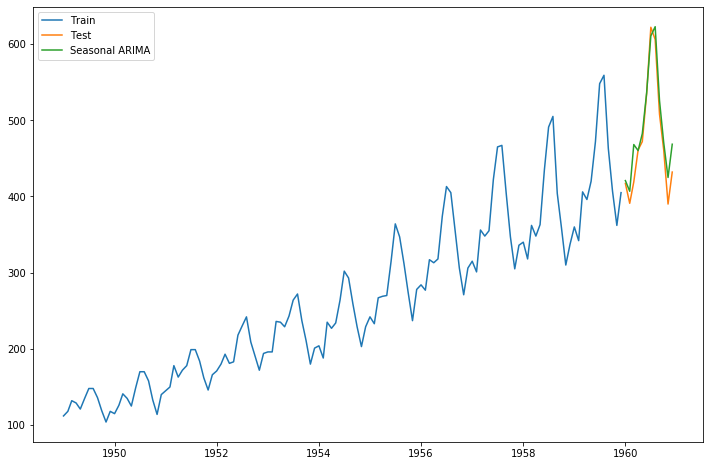

In [37]:
import statsmodels.api as sm

# Seasnality ARIMA 의 eXtension = SARIMAX
arima = sm.tsa.statespace.SARIMAX(
    train['Thousands of Passengers'],
    order=(2,1,1), # Trend 파라미터
    seasonal_order=(0,1,0,12), # Seasonal Prarametr / m = 12
    enforce_stationarity=False, # error가 날경우를 대비하여 끔.
    enforce_invertibility=False) # error가 날경우를 대비하여 끔

# 학습
arima_result = arima.fit()

# forecast는 예측할 데이터의 갯수를 parameter로 받고
# predict는 예측할 데이터의 index를 parameter로 받음.
y_hat['ARIMA'] = arima_result.predict(start='1960-01-01', 
                                      end='1960-12-01',
                                      dynamic=True) 
# ARIMA Model은 다음 Step만 예측가능인데 dynamic True면은 forecast된걸 다음 걸로 넘기고, 또 넘기는 것.
# 약간 반칙성..? ㅇㅇ..

plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['ARIMA'], label='Seasonal ARIMA')
plt.legend()

- Holt-Winter 처럼 잘 따라감.
- **단 루틴 1개 밖에 예측못함 제한되어있음. 매번 모델링 생성 필요**

In [38]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'],y_hat['ARIMA']))
rmse

22.650964227090455